# Apply reconstruction and filter to longer acquisition

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import cma

from scipy.optimize import least_squares, minimize, Bounds
from pathlib import Path

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit


from cryoscope_scripts import load_cryoscope_data
from IIR import (
    step,
    inverse_model_IIR,
    residuals_inverse_IIR,
    multi_exponential_IIR,
    residuals_multi_exponential,
    iter_filter_application
)

from tools import plot_reconstructed_data, plot_signal_filtered, plot_signal_filtered_iter, Signal

FLUX_AMPLITUDE = 0.5
DIRECT = False
ITERATIONS = 5
DATA_START = 0

[Qibo 0.2.12|INFO|2024-12-16 19:41:36]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-16 19:41:36]: Loading platform dummy


In [2]:
data_path = Path.cwd().parent / "cryo_material" / "long_acquisition" / "data" / "cryoscope-0"
data_json = data_path / "data.json"

with open(data_json, "rb") as file:
    data = json.load(file)

flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]
cryoscope_data = load_cryoscope_data(data_path / "data.npz", FLUX_AMPLITUDE)

In [3]:
cryoscope_results = _fit(cryoscope_data)

**Test plot function**

In [4]:
t = np.arange(0,99,1)
start = 10

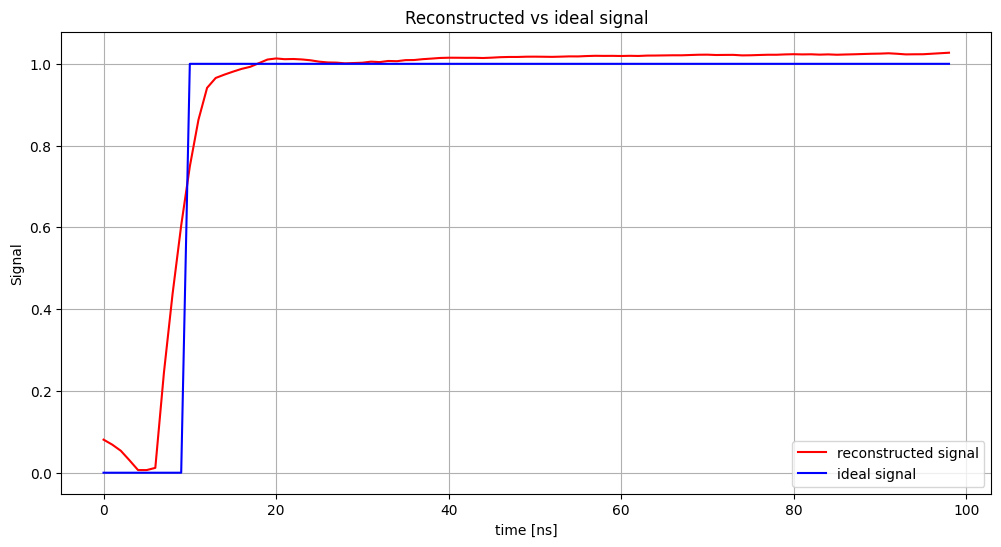

In [ ]:
plot_reconstructed_data(cryoscope_results, "D1", DATA_START, t, start)

### IIR Filters 

In [6]:
#single filter application
initial_guess = [1,1,1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(residuals_inverse_IIR, initial_guess, args=(t, start, step_response))

with open("single_IIR_step.pkl", "wb") as pickle_file:
    pickle.dump(result, pickle_file)

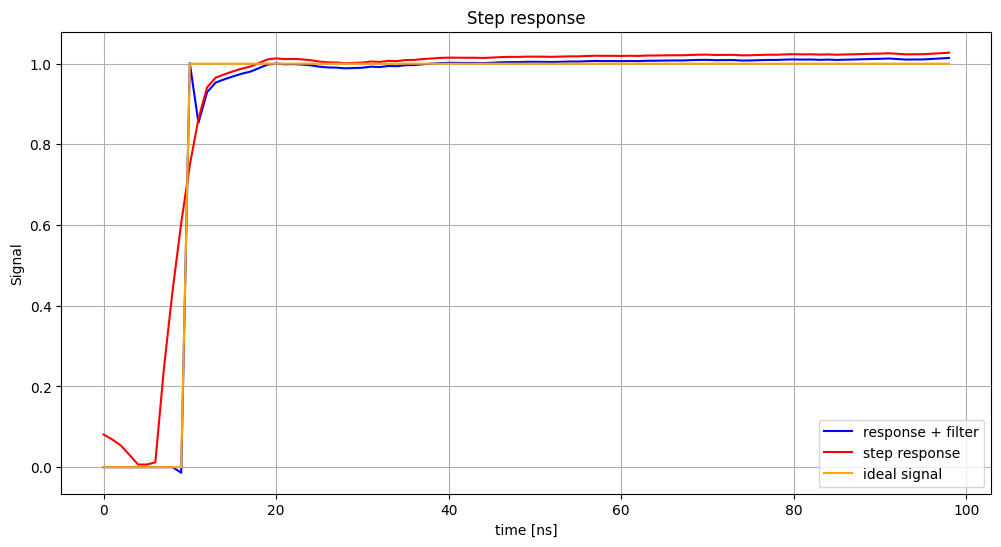

In [7]:
filtered_response = Signal(
    inverse_model_IIR(result.x, t, start, step_response), label="response + filter"
)

response = Signal(step_response, label="step response")

plot_signal_filtered(filtered_response, response, t, start)

### Iterative application of filter

In [9]:
init_guess = [1, 1, 1]

responses, results = iter_filter_application(DIRECT, ITERATIONS, t, start, init_guess, step_response)

with open("5IIR_inverse_step.pkl", "wb") as pickle_file:
    pickle.dump(results, pickle_file)

/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:21: RuntimeWarning: overflow encountered in exp
  return data / (g * (1 + A * np.exp(-(t - start) / tau)))


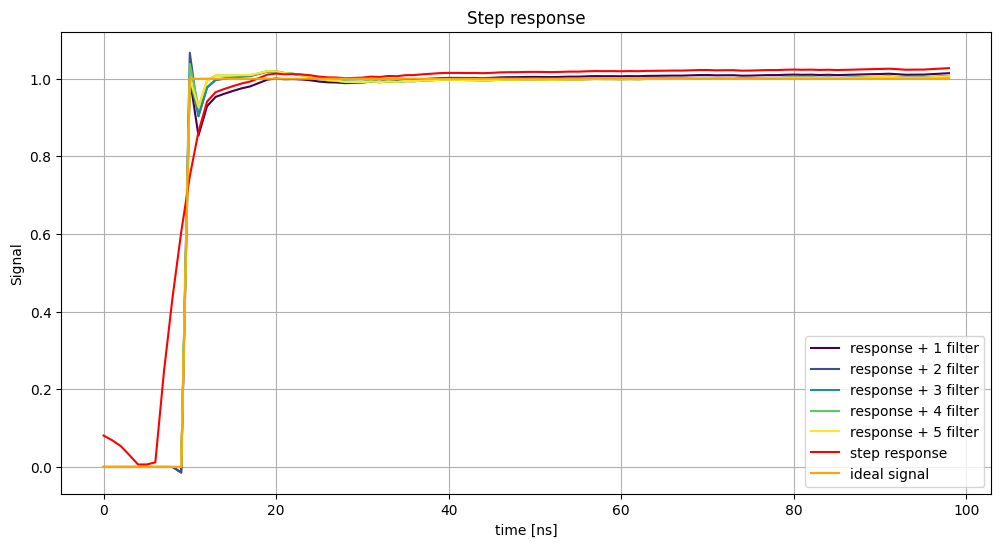

In [9]:
filtered_responses = []
for i in range(5):
    filtered = Signal(responses[i], f"response + {i+1} filter")
    filtered_responses.append(filtered)

response = Signal(cryoscope_results.step_response["D1"], label="step response")

plot_signal_filtered_iter(filtered_responses, response, t, start)

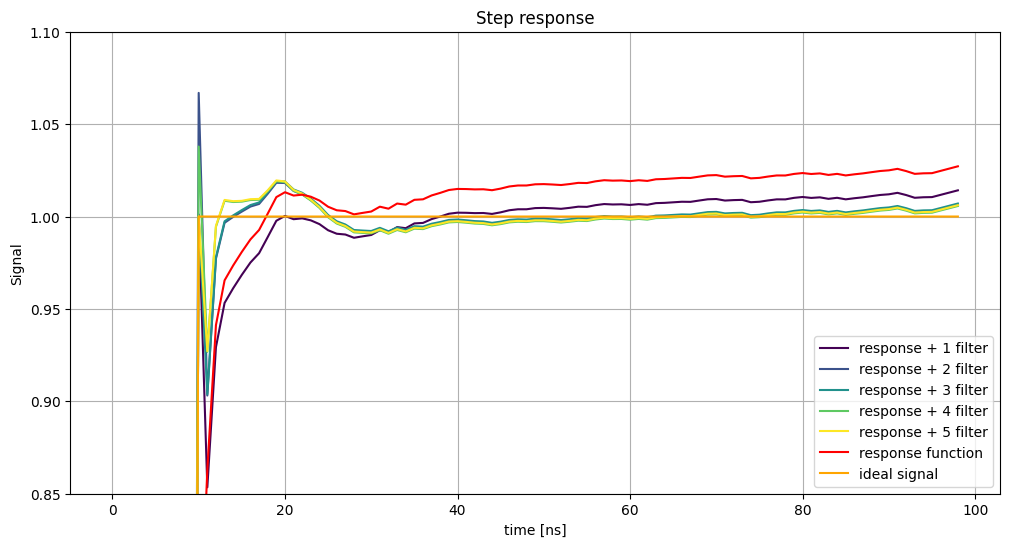

In [10]:
step_response = cryoscope_results.step_response["D1"]
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6))

for i, resp in enumerate(responses):
    plt.plot(t, resp, color=colors[i], label=f"response + {i+1} filter")
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.ylim(0.85, 1.1)
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

**Test filter on monothonically increasing signal**

Test the filter removing the first samples. Test the use of the code from `IIR.py`
The idea in the following is that we should be able to see the signal only from 10 ns on, because we are sending the signal starting at 10 ns, if we see a non-zero signal before is only because the `savitzky-golay` is introducing fictious signal distortions

In [11]:
# single filter application starting optimization from 10ns on

initial_guess = [1, 1, 1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(
    residuals_inverse_IIR, initial_guess, args=(t[10:], start, step_response[10:])
)

with open("single_IIR_ones.pkl", "wb") as pickle_file:
    pickle.dump(result, pickle_file)

**Inverse filter simultaneously optimized**

In [12]:
#fix multi exponential code
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 1]
step_response = cryoscope_results.step_response["D1"]
result = least_squares(
    residuals_multi_exponential, initial_guess, args=(t, start, step_response)
)
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.981e-92 -3.435e-83 ...  9.230e-04  2.037e-03]
           x: [ 1.013e+00  1.463e+00 -2.571e-01  1.010e+00  3.908e+01
               -3.299e-02  1.006e+00  4.820e-02  1.346e-02]
        cost: 0.0005085941716948513
         jac: [[ 1.956e-92 -9.296e-92 ... -8.530e-89  1.472e-90]
               [ 3.392e-83 -1.457e-82 ... -1.331e-79  2.552e-81]
               ...
               [-9.884e-01  0.000e+00 ...  0.000e+00  0.000e+00]
               [-9.895e-01  0.000e+00 ...  0.000e+00  0.000e+00]]
        grad: [-4.865e-06  1.235e-08 -1.377e-07 -4.877e-06  2.659e-10
               -2.004e-06 -4.899e-06  3.469e-12 -5.462e-08]
  optimality: 4.899020094990391e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 82
        njev: 55


/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:27: RuntimeWarning: overflow encountered in multiply
  (g_1 * (1 + A_1 * np.exp(-(t - start) / tau_1)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:27: RuntimeWarning: overflow encountered in exp
  (g_1 * (1 + A_1 * np.exp(-(t - start) / tau_1)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:28: RuntimeWarning: overflow encountered in exp
  * (g_2 * (1 + A_2 * np.exp(-(t - start) / tau_2)))
/home/elisa/Desktop/Qibo/Qibocal/cryoscope/IIR.py:29: RuntimeWarning: overflow encountered in exp
  * (g_3 * (1 + A_3 * np.exp(-(t - start) / tau_3)))


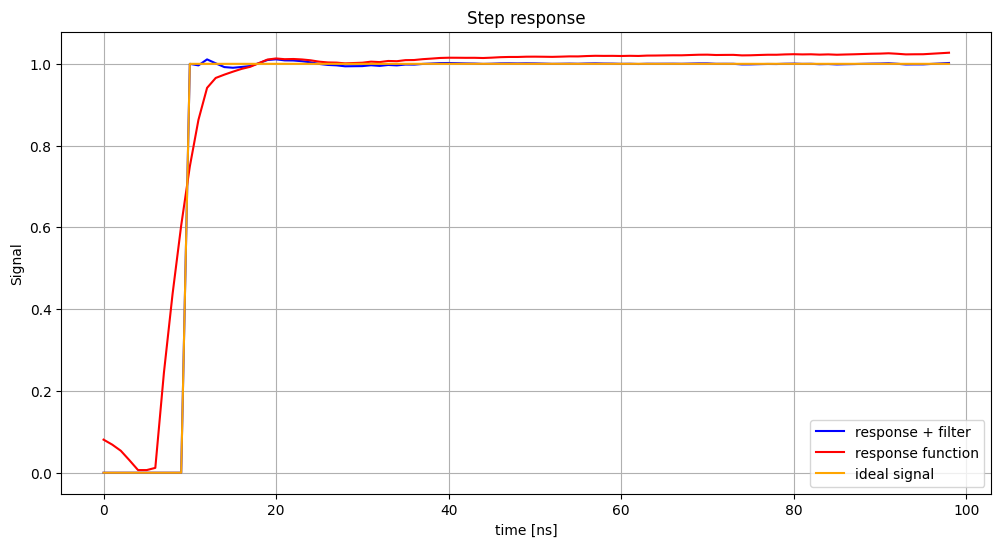

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    multi_exponential_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

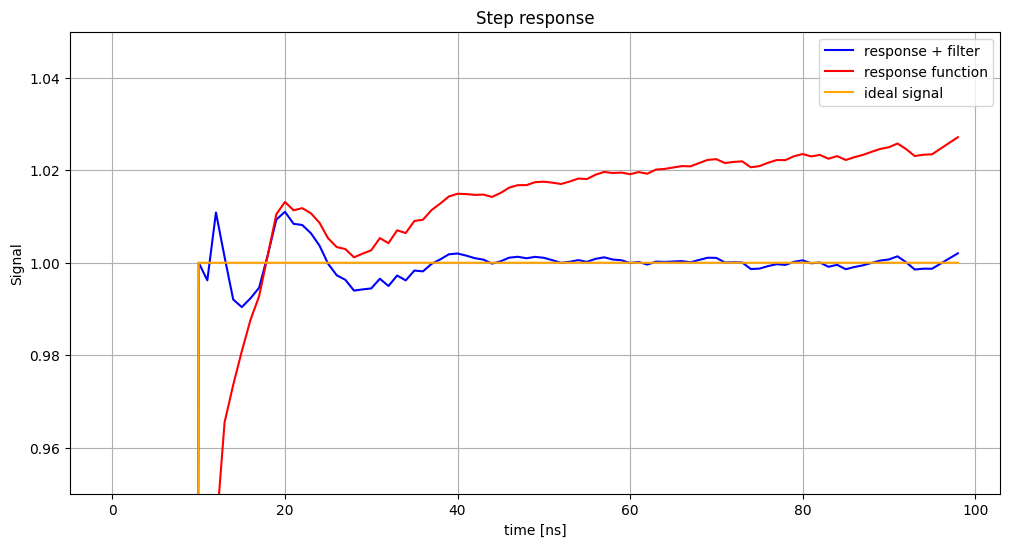

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    multi_exponential_IIR(result.x, t, start, step_response),
    color="blue",
    label="response + filter",
)
plt.plot(step_response, color="red", label="response function")
plt.plot(t, step(t, start), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.ylim(0.95, 1.05)
plt.title("Step response")
plt.legend()
plt.grid()

### Tests on FIR *to be considered later*

From here on I assume for simplicity that the signal starts at 10 ns. In the following I plot how a consider the ideal response, the filtered response and the reconstructed response (this last one is actually not relevant) for the computation of the FIR filter coefficients

In [17]:
reconstructed_response = cryoscope_results.step_response["D1"][10:]
t = np.arange(0,len(reconstructed_response),1)
start = 0

filtered_response = multi_exponential_IIR(result.x, t, start, reconstructed_response)

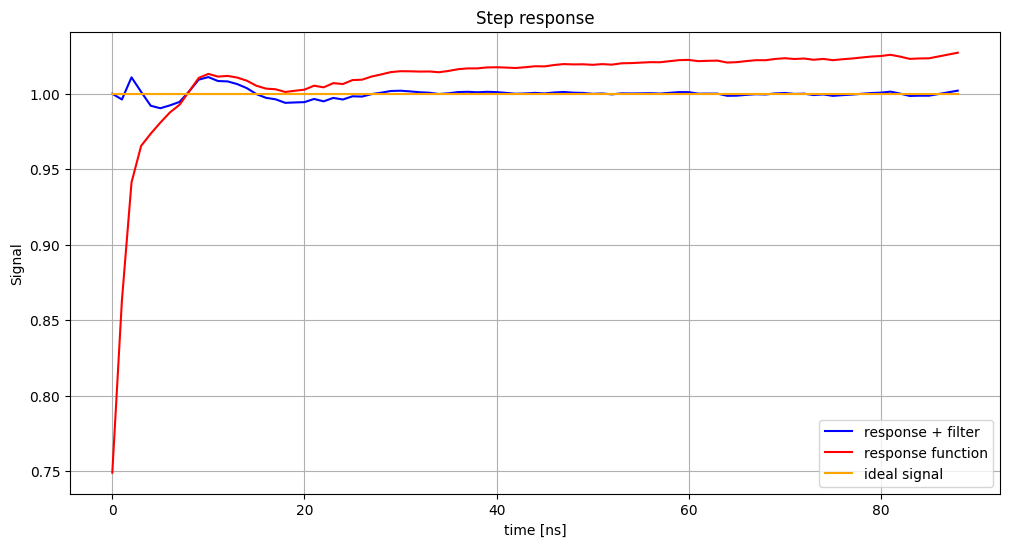

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(reconstructed_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

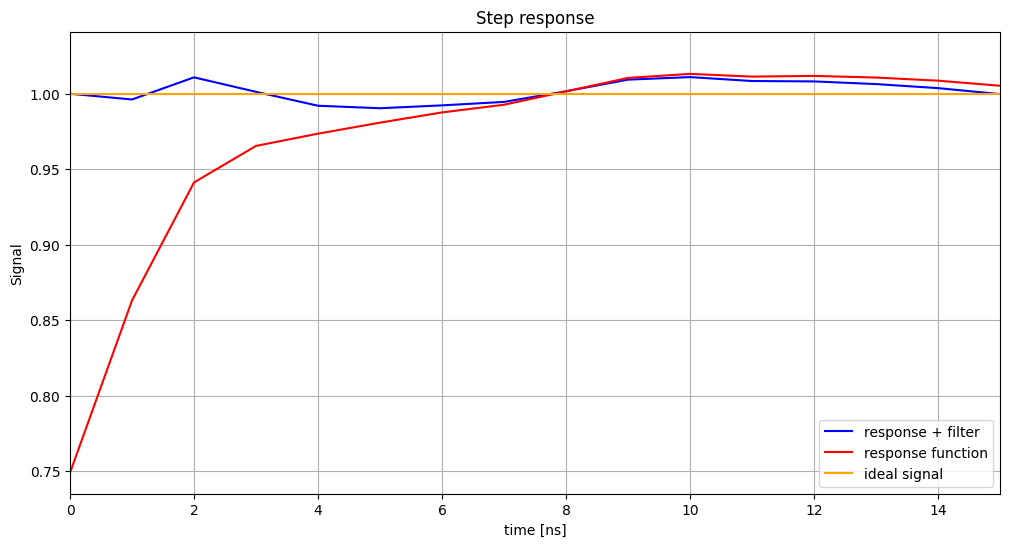

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(
    t,
    filtered_response,
    color="blue",
    label="response + filter",
)
plt.plot(reconstructed_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.xlim(0,15)
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

As first test for the search for the FIR filters I want to look for coefficients for the whole signal. Then, considering the results I get I will decide how to proceed. In the following I line out some possibilities:
* Keep coefficients for the complete signal length (we expect them to go to 0)
* Keep a parameter for more than 2 coefficients
* Reduce the FIR parameters search to the first (eg. 15/20 ns) and then apply the FIR setting higher coefficients to 0


In [20]:
def params_to_coefficients(params, first, len):

    coefficients = params[:first]

    for i in range(0, int((len - first) / 2)):
        coefficients = np.append(coefficients, [params[i], params[i]])

    if len % 2 != 0:
        coefficients = np.append(coefficients, params[-1])

    return coefficients


def FIR_filter(x, coefficients):
    """Applies the FIR filter to the input signal x using coefficients b."""

    y = np.convolve(x, coefficients, mode="same")
    return y


def cost_function(params, signal, t, start):

    length = len(signal)
    coefficients = params_to_coefficients(params, 6, length)

    y=signal#FIR_filter(signal, coefficients)
    mse = np.mean((y - step(t, start)) ** 2)
    #print(step(t,start))
    # print(mse)
    return mse

**FIR filter application on the first 40 ns** 

I try to do the same thing but optimizing considering only the first 40 ns

In [21]:
reconstructed_response = cryoscope_results.step_response["D1"][10:40]

t = np.arange(0, len(reconstructed_response), 1)
start = 0

filtered_response = multi_exponential_IIR(result.x, t, start, reconstructed_response)

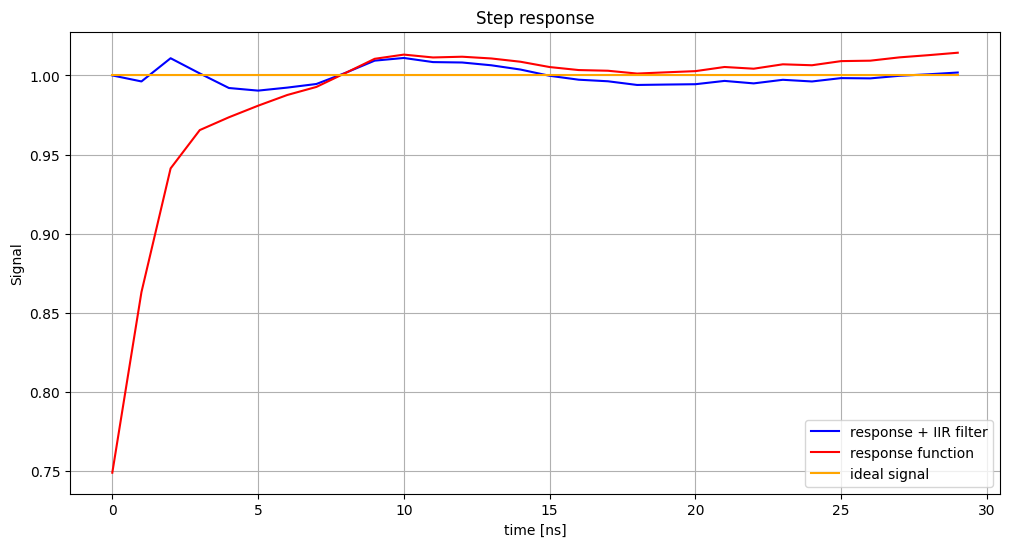

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(
    t, filtered_response, color="blue", label="response + IIR filter")
plt.plot(reconstructed_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [31]:
initial_guess = [1]
[initial_guess.append(0) for i in range(11)]
lower_bounds = [-1] * 12
upper_bounds = [1] * 12
sigma = 0.5

print(len(t))
print(len(filtered_response))
cost_function(initial_guess, filtered_response, t, start)

30
30


3.2469008886404034e-05

In [34]:
result = minimize(
    cost_function,
    initial_guess,
    args=(filtered_response, t, start),
    tol=1e-16,
    bounds = Bounds(lower_bounds, upper_bounds)
)

In [35]:
print(result)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.2469008886404034e-05
        x: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00]
      nit: 0
      jac: [-0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00]
     nfev: 13
     njev: 1
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>


In [24]:
result = cma.fmin2(
    lambda params: cost_function(params, reconstructed_response, t, start),
    initial_guess,
    sigma,
    #options={"bounds": [lower_bounds, upper_bounds]},
)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=244428, Fri Dec 13 16:40:41 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 2.977168317308096e-03 1.0e+00 4.79e-01  5e-01  5e-01 0:00.0
termination on tolfun=1e-11 (Fri Dec 13 16:40:41 2024)
final/bestever f-value = 2.977168e-03 2.977168e-03 after 12/1 evaluations
incumbent solution: [ 0.85247262 -0.11695981 -0.72482702 -0.08610854 -0.48858931  0.00996212
  0.01241851 -0.08731522 ...]
std deviations: [0.47592851 0.47414618 0.48688805 0.47041955 0.48757425 0.48037591
 0.46997684 0.48053732 ...]


In [25]:
print(result[0])

[ 0.89079136  0.18987208 -1.02098964 -0.09592689 -1.21873109  0.00332759
  0.08783073  0.27140438 -0.32119024  0.35946698  0.72654066  0.06217575]


In [26]:
result[1]

In [27]:
coefficients = params_to_coefficients(result[0], 6, len(reconstructed_response))
print(coefficients)

[ 0.89079136  0.18987208 -1.02098964 -0.09592689 -1.21873109  0.00332759
  0.89079136  0.89079136  0.18987208  0.18987208 -1.02098964 -1.02098964
 -0.09592689 -0.09592689 -1.21873109 -1.21873109  0.00332759  0.00332759
  0.08783073  0.08783073  0.27140438  0.27140438 -0.32119024 -0.32119024
  0.35946698  0.35946698  0.72654066  0.72654066  0.06217575  0.06217575]


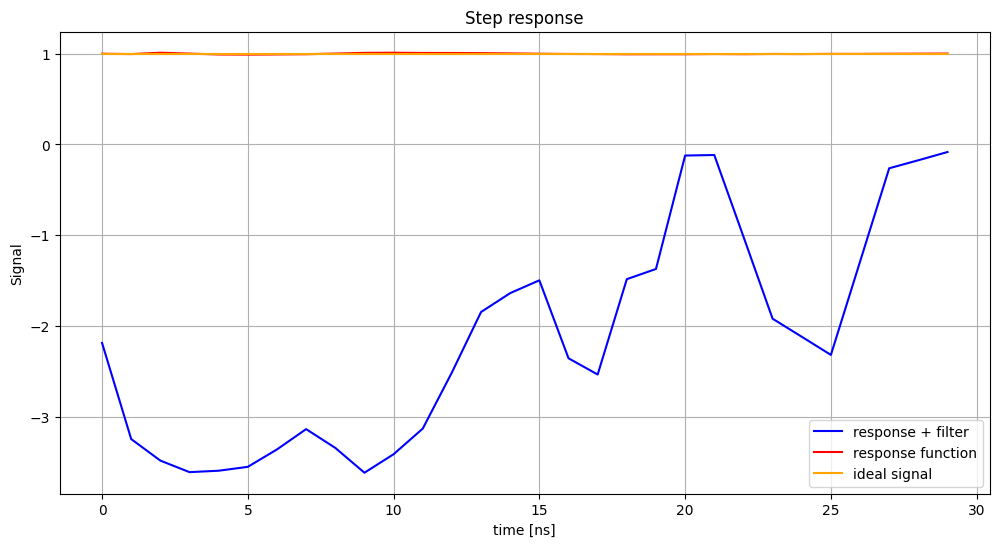

In [28]:
filtered = FIR_filter(reconstructed_response, coefficients)

plt.figure(figsize=(12, 6))
plt.plot(
    t,
    filtered,
    color="blue",
    label="response + filter",
)
plt.plot(filtered_response, color="red", label="response function")
plt.plot(t, step(t, 0), color="orange", label="ideal signal")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

TO DO LIST:

- [] Provare a usare savgol con opzione nearest 
- [] Vedere se conviene variare la WL del savgol 
- [] Provare a cambiare la normalizzazione del savgol
- [] Salvare in maniera sistematica i parametri dei filtri per poterli confrontare (considerato che il modello di filtro da applicare è sempre lo stesso :) )
- [] Provare a creare i filtri a partire da WL diverse e proprietà diverse del savgol, ricavre i filtri, applicare le correzioni ai qubit e vedere con i filtri ricavati dalle diverse ricostruzioni quanto migliora la fidelity dei gate 